In [1]:
import numpy as np
import numba
import math
from numba import njit, jit

@jit(nopython=True, fastmath=True, parallel=True, nogil=True)
def trilinear_interpolate_volume(
    volume,
    xyz,
):
    ijk = xyz.astype(np.int32)
    xyz = xyz - ijk
    Vxyz = np.zeros(len(xyz), dtype=np.float32)
    for m in numba.prange(len(xyz)):
        i, j, k = ijk[m, 0], ijk[m, 1], ijk[m, 2]
        x, y, z = xyz[m, 0], xyz[m, 1], xyz[m, 2]
        V000 = volume[ i   , j   ,  k   ]
        V100 = volume[(i+1), j   ,  k   ]
        V010 = volume[ i   ,(j+1),  k   ]
        V001 = volume[ i   , j   , (k+1)]
        V101 = volume[(i+1), j   , (k+1)]
        V011 = volume[ i   ,(j+1), (k+1)]
        V110 = volume[(i+1),(j+1),  k   ]
        V111 = volume[(i+1),(j+1), (k+1)]
        Vxyz[m] = (V000 * (1 - x)*(1 - y)*(1 - z)
                + V100 * x * (1 - y) * (1 - z) +
                + V010 * (1 - x) * y * (1 - z) +
                + V001 * (1 - x) * (1 - y) * z +
                + V101 * x * (1 - y) * z +
                + V011 * (1 - x) * y * z +
                + V110 * x * y * (1 - z) +
                + V111 * x * y * z)
    return Vxyz

@jit(nopython=True, fastmath=True, parallel=True, nogil=True)
def trilinear_interpolate_volume_and_mask(
    volume,
    volume_mask,
    xyz,
):
    ijk = xyz.astype(np.int32)
    xyz = xyz - ijk
    Vxyz = np.zeros(len(xyz), dtype=np.float32)
    VMxyz = np.zeros(len(xyz), dtype=np.float32)
    for m in numba.prange(len(xyz)):
        i, j, k = ijk[m, 0], ijk[m, 1], ijk[m, 2]
        x, y, z = xyz[m, 0], xyz[m, 1], xyz[m, 2]
        V000 = volume[ i   , j   ,  k   ]
        V100 = volume[(i+1), j   ,  k   ]
        V010 = volume[ i   ,(j+1),  k   ]
        V001 = volume[ i   , j   , (k+1)]
        V101 = volume[(i+1), j   , (k+1)]
        V011 = volume[ i   ,(j+1), (k+1)]
        V110 = volume[(i+1),(j+1),  k   ]
        V111 = volume[(i+1),(j+1), (k+1)]
        Vxyz[m] = (V000 * (1 - x)*(1 - y)*(1 - z)
                + V100 * x * (1 - y) * (1 - z) +
                + V010 * (1 - x) * y * (1 - z) +
                + V001 * (1 - x) * (1 - y) * z +
                + V101 * x * (1 - y) * z +
                + V011 * (1 - x) * y * z +
                + V110 * x * y * (1 - z) +
                + V111 * x * y * z)
        VM000 = volume_mask[ i   , j   ,  k   ]
        VM100 = volume_mask[(i+1), j   ,  k   ]
        VM010 = volume_mask[ i   ,(j+1),  k   ]
        VM001 = volume_mask[ i   , j   , (k+1)]
        VM101 = volume_mask[(i+1), j   , (k+1)]
        VM011 = volume_mask[ i   ,(j+1), (k+1)]
        VM110 = volume_mask[(i+1),(j+1),  k   ]
        VM111 = volume_mask[(i+1),(j+1), (k+1)]
        VMxyz[m] = (VM000 * (1 - x)*(1 - y)*(1 - z)
                + VM100 * x * (1 - y) * (1 - z) +
                + VM010 * (1 - x) * y * (1 - z) +
                + VM001 * (1 - x) * (1 - y) * z +
                + VM101 * x * (1 - y) * z +
                + VM011 * (1 - x) * y * z +
                + VM110 * x * y * (1 - z) +
                + VM111 * x * y * z)
    return Vxyz, VMxyz

In [2]:
import cv2
import time
import scipy
import numpy as np
import pandas as pd
import Geometry3D as g3d
import matplotlib.pyplot as plt

%matplotlib inline

def random_rotate_slice(volume, idx, angle, volume_mask=None, render=True):
    """
    volume: 3D volume to be rotated and sliced. Expected to have dim of [z, y, x]
    idx: slice index along z axis
    rotate_limit: rotation limit in degree
    """
    # get shape
    volume_depth, volume_height, volume_width = volume.shape
    
    # uniformly sample rotation angle and compute the normal vector of the rotated slice plane
    # note that when computing transformation matrix, coordinates are in format of [x, y, z]
    theta = angle / 360 * 2 * np.pi
    rot_mat = cv2.Rodrigues(theta)[0]
    normal_vector = np.dot(np.array([0, 0, 1]), rot_mat.T)
    
    # compute the intersection points between slicing plane and volume
    box = g3d.Parallelepiped(g3d.origin(), volume_width*g3d.x_unit_vector(), volume_height*g3d.y_unit_vector(), volume_depth*g3d.z_unit_vector())
    center = g3d.Point(volume_width/2, volume_height/2, idx)
    plane = g3d.Plane(center, g3d.Vector(*normal_vector.tolist()))
    intersection = g3d.intersection(box, plane)
    inter_points = np.array([[pt.x, pt.y, pt.z] for pt in intersection.points])
    
    # visualize
    # need to modify Geometry source to enable 3d render for notebook
    # Geometry3D/render/renderer_matplotlib.py Line 27
    # replace `ax = Axes3D(fig)` with `ax = fig.add_subplot(projection='3d')`
    if render:
        r = g3d.Renderer(backend='matplotlib')
        r.add((box, "r", 5))
        r.add((intersection, "b", 5))
        r.show()
    
    # compute transform matrix
    v1 = inter_points[0] - inter_points[1]
    v2 = normal_vector
    v1 = v1 / np.sqrt(np.sum(v1**2))
    v2 = v2 / np.sqrt(np.sum(v2**2))
    v3 = np.cross(v1, v2)
    G = np.stack([v3, v1, v2]) # new_coord dot_product G = orig_coord
    
    # compute bounding box
    new_points = np.dot(inter_points, G.T) # new points are projected to the xy plane so we can get the minimum bounding box
    x_min, y_min, x_max, y_max = np.min(new_points[:, 0]), np.min(new_points[:, 1]), np.max(new_points[:, 0]), np.max(new_points[:, 1])
    z_mean = np.mean(new_points[:, 2])
    width, height = int(x_max - x_min), int(y_max - y_min)
    bias = np.array([x_min, y_min, z_mean])
    
    # meshgrid
    start_time = time.time()
    x = np.linspace(0, width-1, width)
    y = np.linspace(0, height-1, height)
    grid = np.stack(np.meshgrid(x, y, indexing="ij"), axis=-1)
    grid = np.pad(grid, ((0, 0), (0, 0), (0, 1)))
    grid = grid + bias
    orig_coords = np.dot(grid, G)
    orig_coords = orig_coords[..., ::-1].astype(np.float32) # back to [z, y, x] format for interpolation
    orig_coords = orig_coords.reshape(-1, 3)
    x_valid = (orig_coords[:, 2]>0)&(orig_coords[:, 2]<volume_width-1)
    y_valid = (orig_coords[:, 1]>0)&(orig_coords[:, 1]<volume_height-1)
    z_valid = (orig_coords[:, 0]>0)&(orig_coords[:, 0]<volume_depth-1)
    valid = x_valid & y_valid & z_valid
    
    # interpolate
    if volume_mask is not None:
        image = np.zeros(width*height, dtype=np.float32)
        mask = np.zeros(width*height, dtype=np.float32)
        start_time = time.time()
        image_valid, mask_valid = trilinear_interpolate_volume_and_mask(volume, volume_mask, orig_coords[valid])
        print(f"interpolate time: {time.time()-start_time}")
        image[valid] = image_valid
        mask[valid] = mask_valid
        image = image.reshape(width, height)
        mask = mask.reshape(width, height)
        return image, mask
    else:
        image = np.zeros(width*height, dtype=np.float32)
        start_time = time.time()
        image_valid = trilinear_interpolate_volume(volume, orig_coords[valid])
        print(f"interpolate time: {time.time()-start_time}")
        image[valid] = image_valid
        image = image.reshape(width, height)
        return image


In [3]:
import os
from tqdm import tqdm

volume = np.memmap("/dev/shm/memmap/kidney_1_dense.mmap", dtype=np.uint16, shape=(2279, 1303, 912), mode="r")
volume_mask = np.memmap("/dev/shm/memmap/kidney_1_dense_mask.mmap", shape=(2279, 1303, 912), mode="r")

/tmp/ipykernel_19655/3460464377.py:7: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=Reds_alpha_objects)


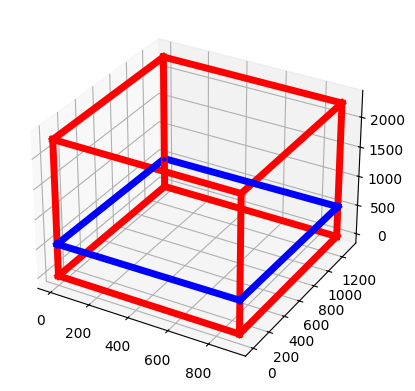

interpolate time: 2.3239736557006836


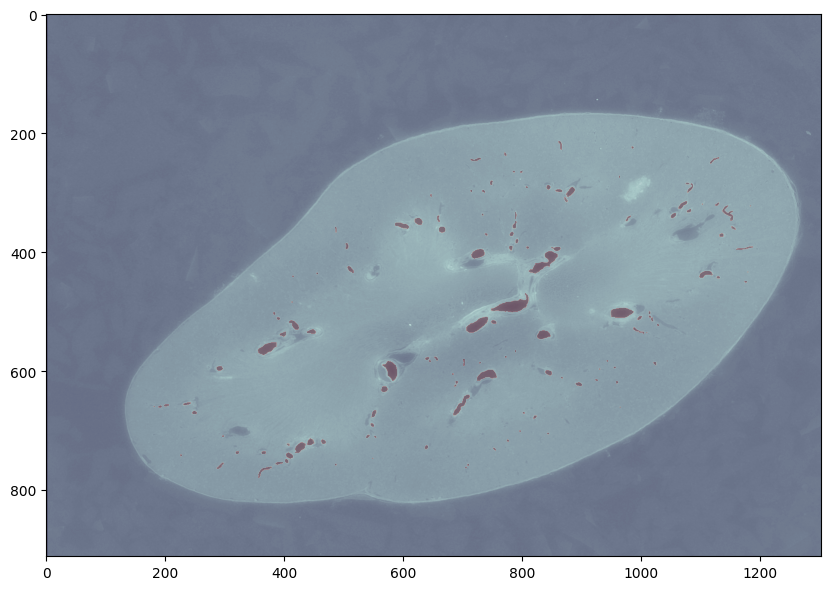

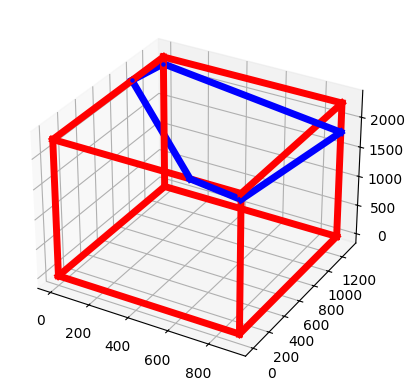

interpolate time: 0.046829938888549805


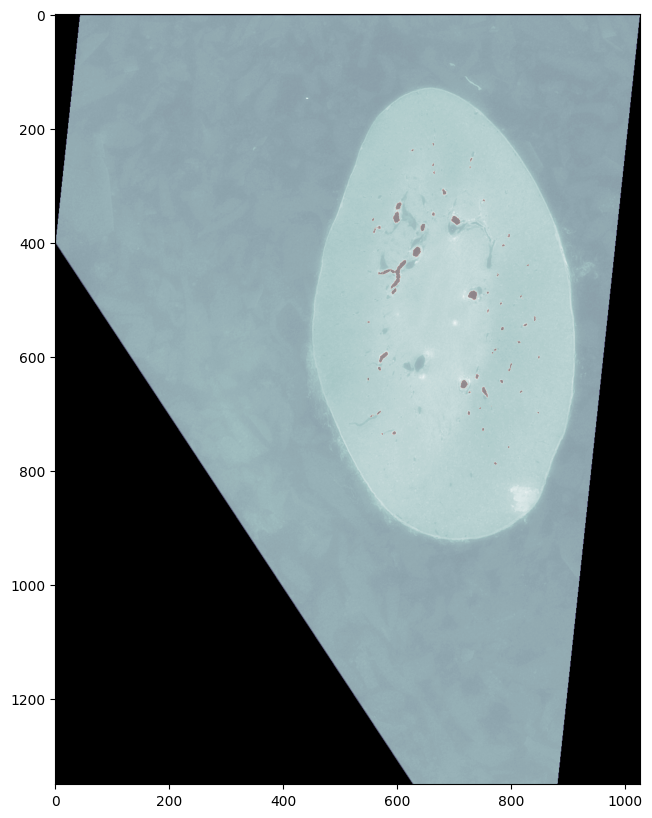

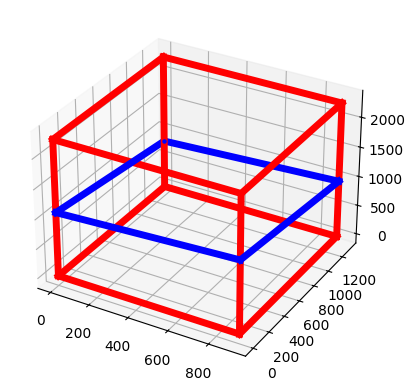

interpolate time: 0.04676675796508789


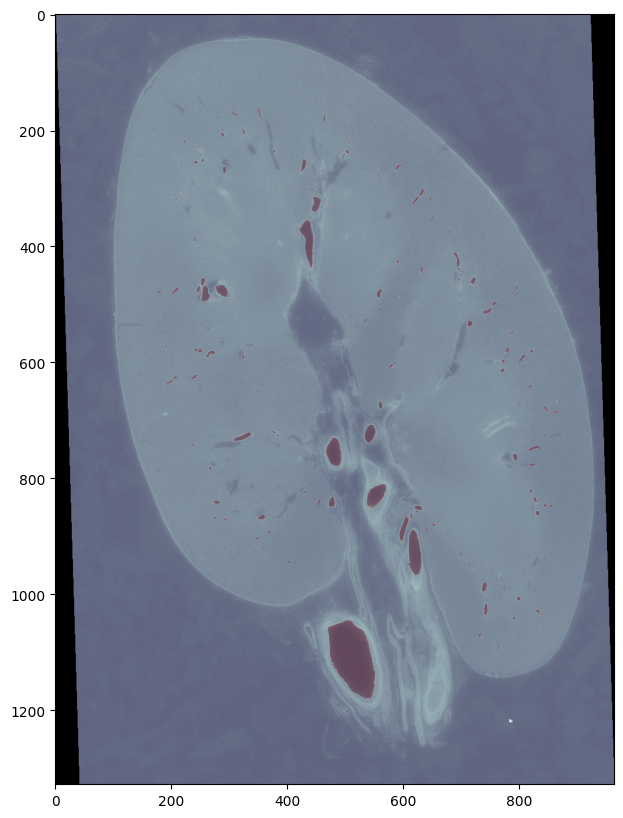

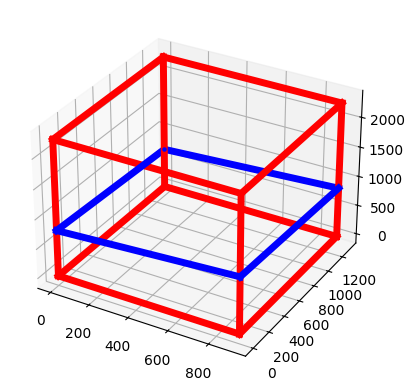

interpolate time: 0.056670427322387695


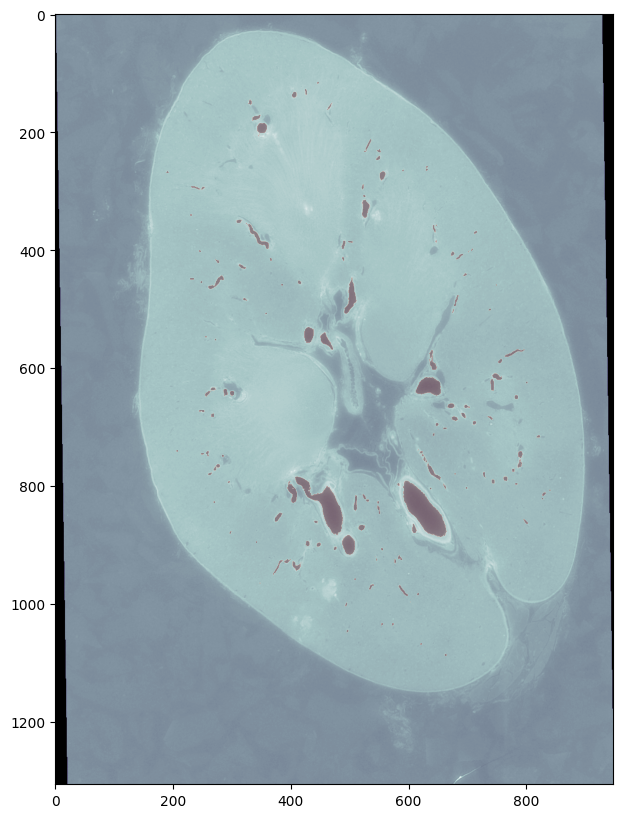

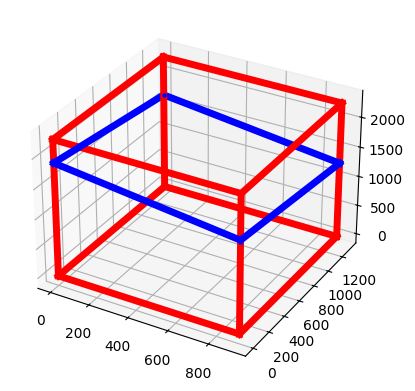

interpolate time: 0.06773495674133301


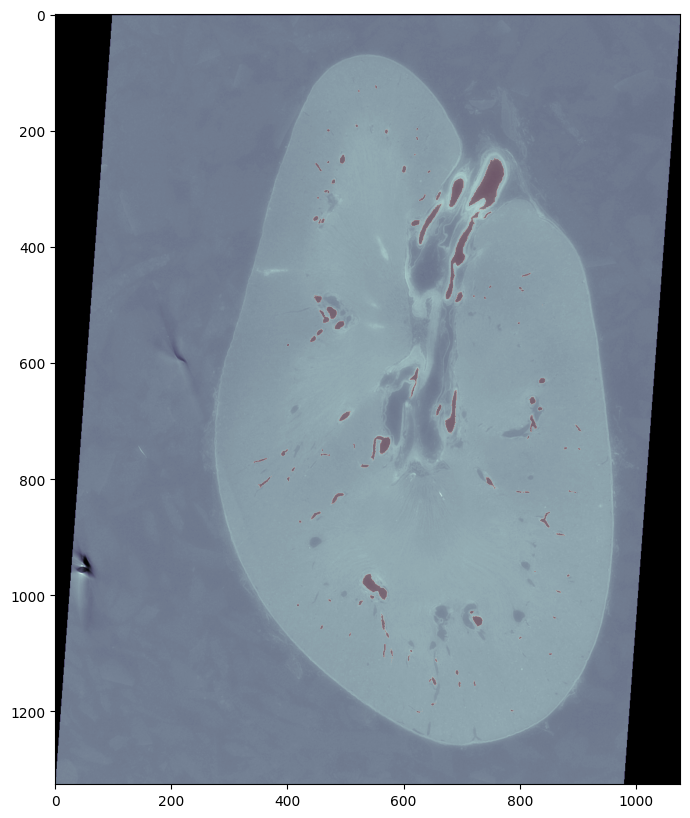

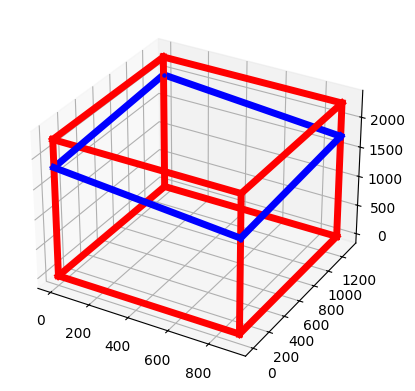

interpolate time: 0.051503896713256836


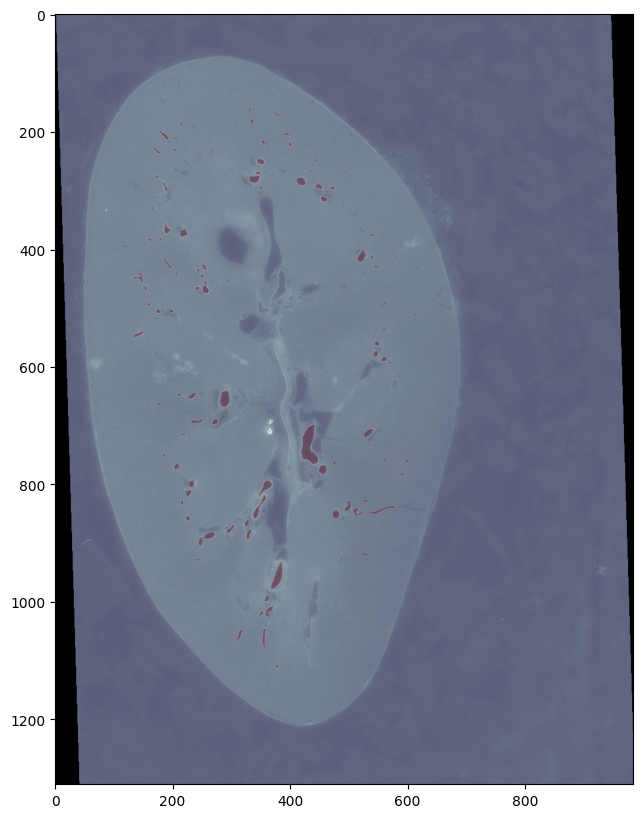

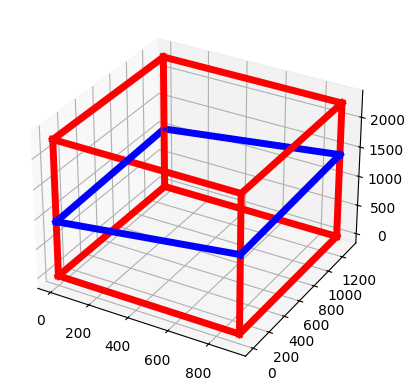

interpolate time: 0.055791378021240234


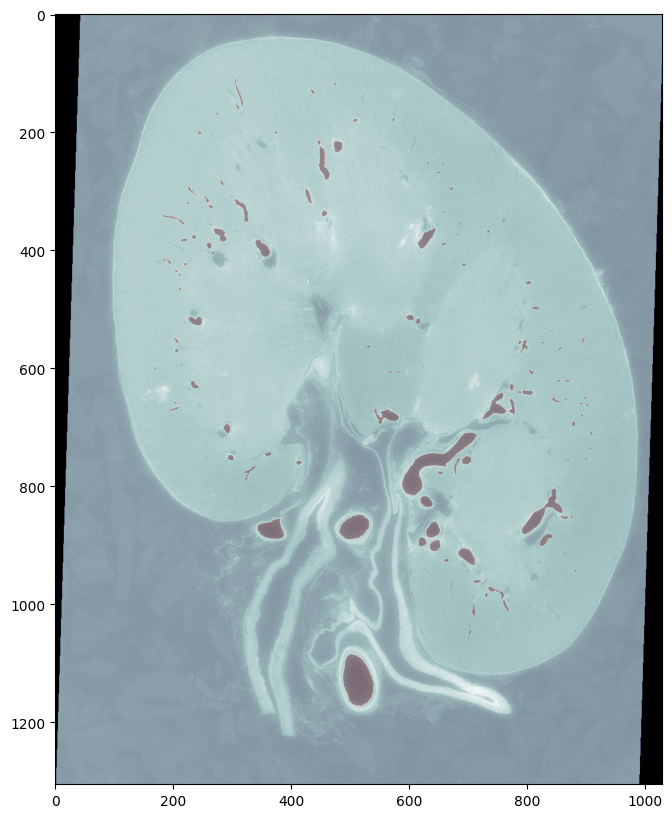

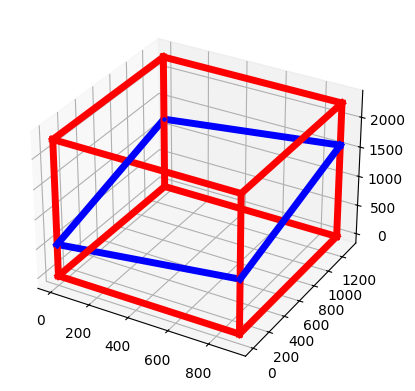

interpolate time: 0.057890892028808594


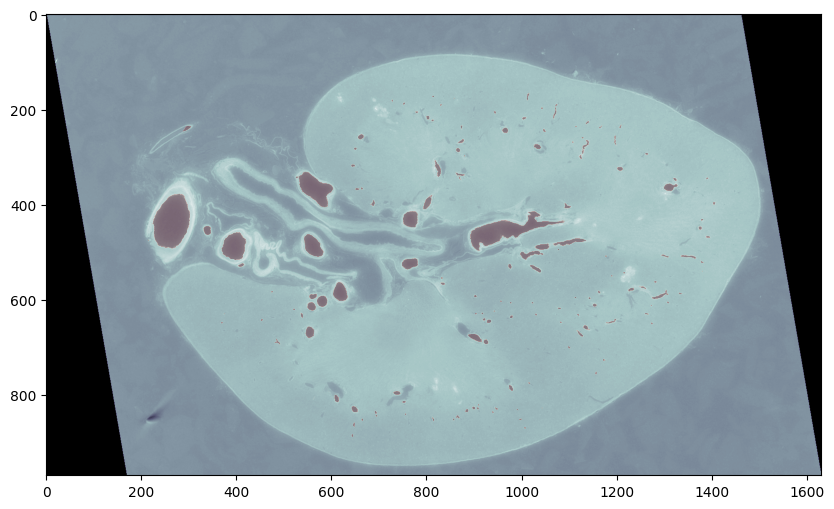

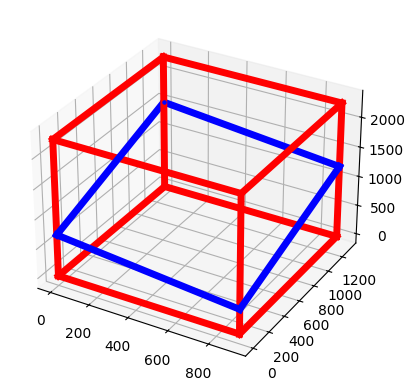

interpolate time: 0.06172370910644531


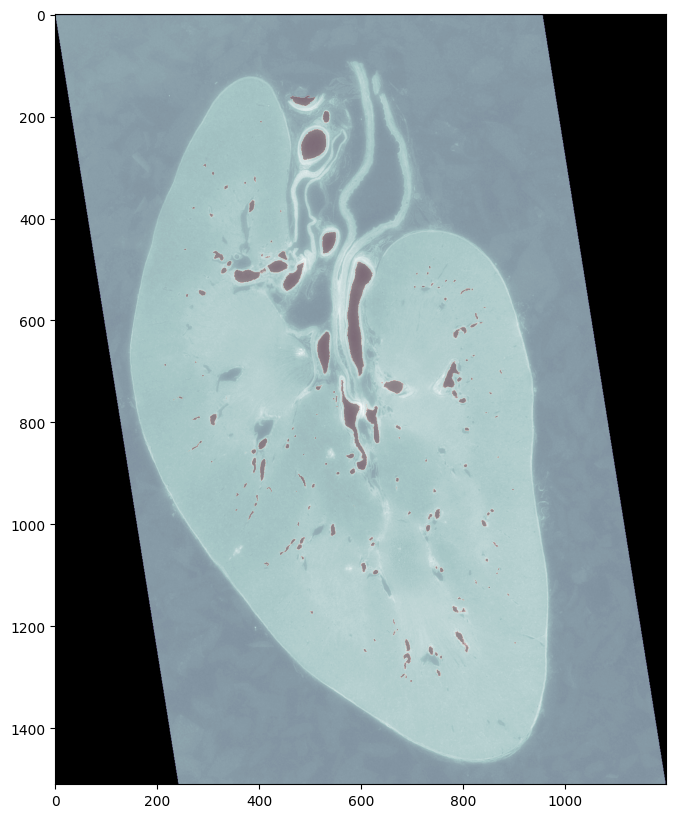

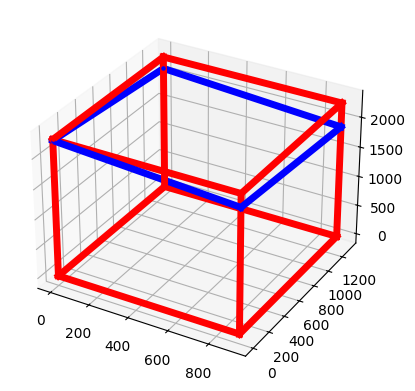

interpolate time: 0.05489015579223633


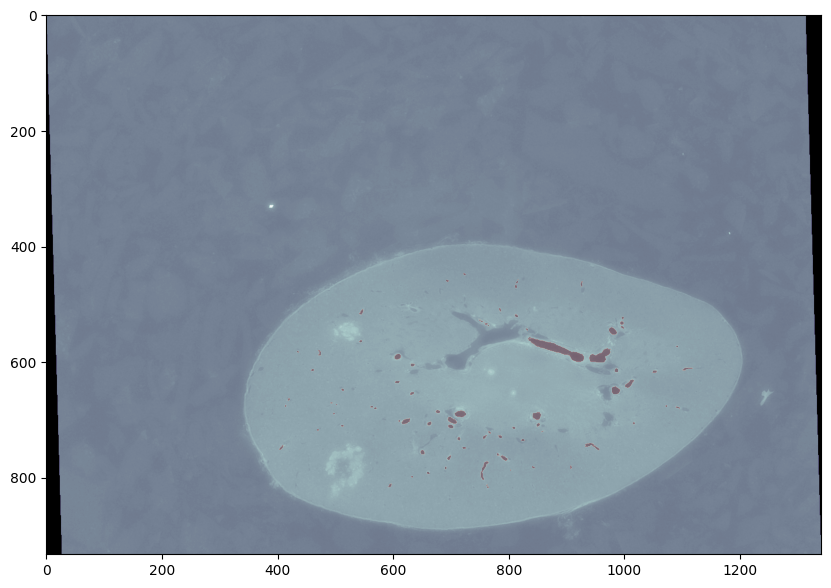

In [4]:
from matplotlib.colors import LinearSegmentedColormap
# get colormap
nalphas = 256
color_array = plt.get_cmap('Reds')(range(nalphas))
color_array[:, -1] = np.linspace(0, 1, nalphas)
Reds_alpha_objects = LinearSegmentedColormap.from_list(name='Reds_alpha', colors=color_array)
plt.register_cmap(cmap=Reds_alpha_objects)  

for i in range(10):
    idx = np.random.choice(range(volume.shape[0]))
    angle = np.random.uniform(-30, 30, size=3)
    image, mask = random_rotate_slice(volume, idx, angle, volume_mask=volume_mask, render=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(image.astype(np.float32)/65535.0, cmap="bone")
    plt.imshow(mask>0, cmap="Reds_alpha", alpha=0.3)
    plt.show()